# Liver Cirhosis Risk Prediction/Classification

## Data Preprocessing

In [306]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [307]:
#Load Dataset
cir_df = pd.read_csv("cirrhosis.csv")

In [308]:
#Check duplicate
len(pd.unique(cir_df["ID"])) == len(cir_df.index)

True

In [309]:
cir_df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

<Axes: >

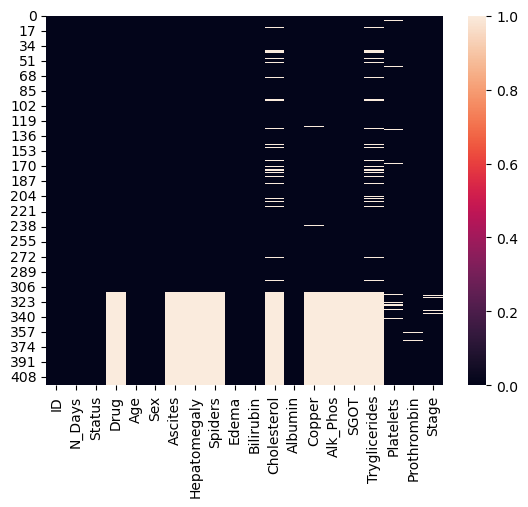

In [310]:
sns.heatmap(cir_df.isnull())

In [311]:
cir_df = cir_df.drop(columns = ["ID"])
#Drop rows with too much null value
cir_df = cir_df[cir_df["Drug"].isna() == False]
#Impute other null value with median
fill_values = {"Tryglicerides": np.nanmedian(cir_df["Tryglicerides"]), 
               "Platelets": np.nanmedian(cir_df["Platelets"]), 
               "Cholesterol": np.nanmedian(cir_df["Cholesterol"]), 
               "Copper": np.nanmedian(cir_df["Copper"])}
cir_df = cir_df.fillna(value = fill_values)
#Replace binary values with 0,1
cir_df["Sex"] = np.where(cir_df["Sex"] == "M",1,0)
cir_df["Ascites"] = np.where(cir_df["Ascites"] == "Y",1,0)
cir_df["Hepatomegaly"] = np.where(cir_df["Hepatomegaly"] == "Y",1,0)
cir_df["Spiders"] = np.where(cir_df["Spiders"] == "Y",1,0)
cir_df["Drug"] = np.where(cir_df["Drug"] == "D-penicillamine",1,0)
cir_df["Stage"] = "stage_" + cir_df["Stage"].astype(int).astype(str)

In [312]:
cir_df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,1,21464,0,1,1,1,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,stage_4
1,4500,C,1,20617,0,0,1,1,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,1012,D,1,25594,1,0,0,0,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,stage_4
3,1925,D,1,19994,0,0,1,1,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,stage_4
4,1504,CL,0,13918,0,0,1,1,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


## EDA

In [314]:
cir_df.describe()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000
mean,2006.362179,0.506410,18269.442308,0.115385,0.076923,0.512821,0.288462,3.256090,364.125000,3.520000,97.490385,1982.655769,122.556346,123.096154,261.871795,10.725641
std,1123.280843,0.500762,3864.805407,0.319999,0.266897,0.500639,0.453775,4.530315,221.923027,0.419892,85.360932,2140.388824,56.699525,62.122820,94.993533,1.004323
min,41.000000,0.000000,9598.000000,0.000000,0.000000,0.000000,0.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000
25%,1191.000000,0.000000,15427.750000,0.000000,0.000000,0.000000,0.000000,0.800000,255.750000,3.310000,41.750000,871.500000,80.600000,87.000000,200.000000,10.000000
50%,1839.500000,1.000000,18187.500000,0.000000,0.000000,1.000000,0.000000,1.350000,309.500000,3.550000,73.000000,1259.000000,114.700000,108.000000,257.000000,10.600000
75%,2697.250000,1.000000,20715.000000,0.000000,0.000000,1.000000,1.000000,3.425000,392.250000,3.800000,123.000000,1980.000000,151.900000,145.250000,322.000000,11.100000
max,4556.000000,1.000000,28650.000000,1.000000,1.000000,1.000000,1.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000


In [303]:
continous_df = cir_df.loc[:, ~cir_df.columns.isin(['Status', 'Stage', 'Edema','Drug','Sex','Ascites','Hepatomegaly','Spiders'])]
histogram = continous_df.hist(figsize=(13, 10), bins = 15 ,grid = False, edgecolor='black', linewidth = 0.4)

In [304]:
category_df = cir_df.loc[:, cir_df.columns.isin(['Status', 'Stage', 'Edema','Drug','Sex','Ascites','Hepatomegaly','Spiders'])]
fig, ax = plt.subplots(2, 4, figsize = (17,8))
axis = [['Status', 'Sex','Drug','Edema'],['Spiders','Ascites','Hepatomegaly','Stage']]
for i in range(2):
    for j in range(4):
        subplot = sns.countplot(ax = ax[i,j] ,x = axis[i][j], data = category_df)

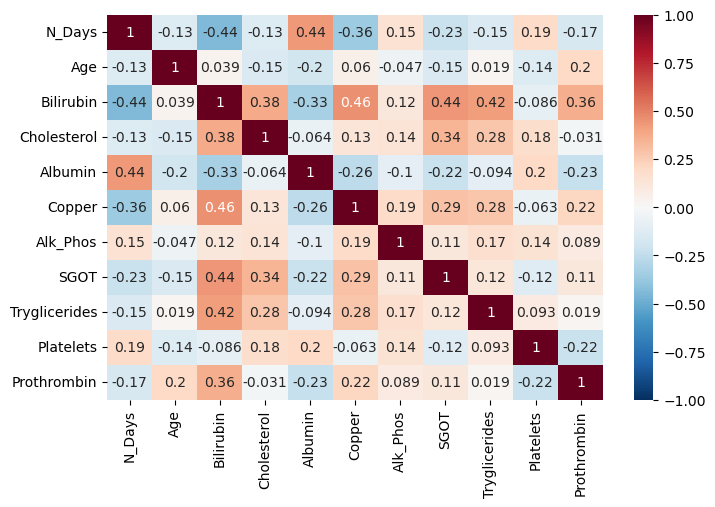

In [244]:
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(continous_df.corr(), cmap = 'RdBu_r', vmin=-1, vmax=1, annot=True)

In [290]:
cir_df = cir_df.drop(columns = ['Status','N_Days'])

## Model

### Spliting Data
#### Main steps:
1. one-hot encoding for Edema (sklearn or manual)
2. Train,val,test split using sklearn


In [21]:
 #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

 #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

### Proportional Odds Model
#### Main steps:
1. Prepare duplicate dataset
1. Convert outcome (Stage) into categorical value
2. fit proportional odds model for remaining data
3. Feature selection (How?) ***

In [9]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
#Or use R

In [18]:
cir_df["Stage"] = cir_df["Stage"].astype("category")

In [288]:
from pandas.api.types import CategoricalDtype
stage_type = CategoricalDtype(categories=["stage_1", "stage_2", "stage_3","stage_4"], ordered=True)
cir_df["Stage"].astype(stage_type).dtype

CategoricalDtype(categories=['stage_1', 'stage_2', 'stage_3', 'stage_4'], ordered=True)

### Multilayer Perceptron Neural Network
#### Main steps:
1. Build function finding optimal number of layer and neurons (tensorflow).
2. Feature selection ***

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#Need one-hot encoding for Endema and stage

$N_h = \frac{N_s}{\alpha  (N_i+N_o)}$

### XGBoost
#### Mainsteps:
1. Fit model using xgboost
1. Feature selection ***

In [285]:
##Do not require scaling or normalization

In [ ]:
## Feature selection: feature importance plot

## Performance Evaluation